<a href="https://colab.research.google.com/github/fzantalis/colab_collection/blob/master/Audio_Keyframe_Generator_For_Deforum_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Audio Keyframe Generator For Deforum Stable Diffusion**
This notebook will automatically generate keyframes for deforum stable diffusion settings

[Deforum Stable Diffusion](https://colab.research.google.com/github/fzantalis/deforum-stable-diffusion-audio/blob/main/Deforum_Stable_Diffusion.ipynb) 

In deforum Stable Diffusion you can control animation settings like zoom/angle etc based on a music aplitudes. To do so, we need to analyze a music track and generate a keyframe string. This notebook automates the whole process for us. 

More specifically, you can upload a music track and the notebook will decompose the track to separate music elements like drums, bass and vocals. Using a single element to drive the animation settings seems to be working better.

Then, based on the music elements a keyframe string is automatically generated.

#Audio Settings

In [1]:
#@markdown **1. Install the mandatory libraries. Demucs will help us decompose our music track to seperate instruments and vocals**
!pip install -q demucs
!pip install -q eyed3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 KB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.3/446.3 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 898.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.6/189.6 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 KB 873.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━

In [2]:
#@markdown **2. Upload your music track**
from google.colab import files 
uploaded = files.upload() 
for name, data in uploaded.items():
  with open('audio_file.mp3', 'wb') as f:
    f.write(data)

Saving antio_twra_sample.mp3 to antio_twra_sample.mp3


In [3]:
#@markdown **3. Decompose your music track with demucs**
!python -m demucs.separate --mp3 --mp3-bitrate=128 audio_file.mp3

Important: the default model was recently changed to `htdemucs` the latest Hybrid Transformer Demucs model. In some cases, this model can actually perform worse than previous models. To get back the old default model use `-n mdx_extra_q`.
Downloading: "https://dl.fbaipublicfiles.com/demucs/hybrid_transformer/955717e8-8726e21a.th" to /root/.cache/torch/hub/checkpoints/955717e8-8726e21a.th
100% 80.2M/80.2M [00:01<00:00, 49.1MB/s]
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /content/separated/htdemucs
Separating track audio_file.mp3
100%|██████████████████████████████████████████████| 35.099999999999994/35.099999999999994 [01:20<00:00,  2.29s/seconds]


In [8]:
import IPython
#@title 4. Select the audio element that you want to isolate
element = 'drums' #@param ["drums", "bass", "vocals", "other"]
audio_file = "separated/htdemucs/audio_file/" + element + ".mp3"
IPython.display.Audio(filename=audio_file)

### Preview the audio waveform

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


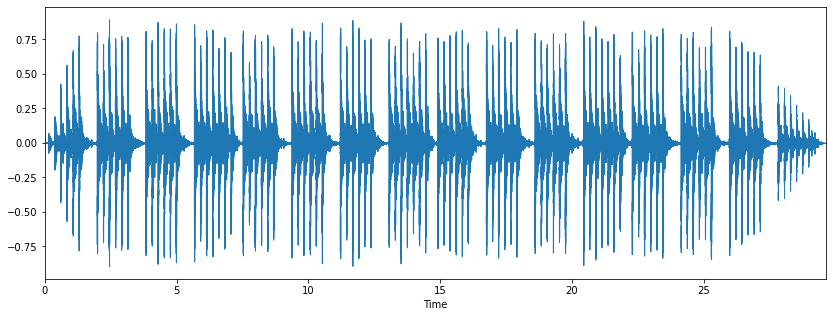

In [14]:
#@markdown **5. Print the audio waveform**
import librosa
x, sr = librosa.load(audio_file)

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

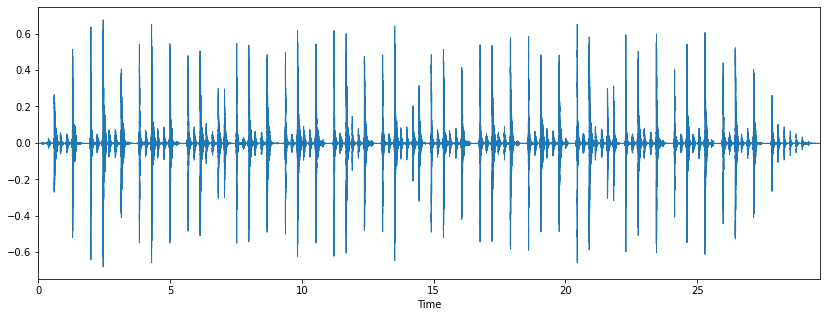

In [15]:
#@markdown **6. Print the hpss modified waveform**
from matplotlib import pyplot as plt
import numpy as np

wav_harmonic, wav_percussive = librosa.effects.hpss(x, margin=(1.0, 5.0))
plt.figure(figsize=(14, 5))
librosa.display.waveplot(wav_percussive)

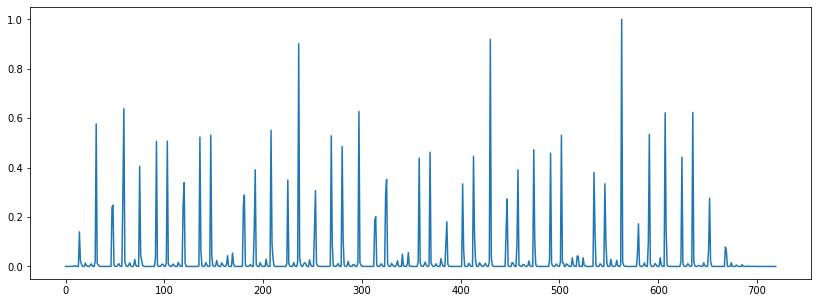

In [16]:
import eyed3
#@title **7. Scale the waveform according to your FPS and Audio duration and get the normalized amplitudes**
fps = 24 #@param  {type:"number"}
n_mels = 512 #@param {type:"number"}
function = "1 + amplitude**2" #@param {type:"string"}
#@markdown This is a function to apply to each frame value, where 'amplitude' is the original amplitude between 0 and 1

frame_duration = int(sr / fps)
duration = round(eyed3.load(audio_file).info.time_secs)

# Generate Mel Spectrogram
spec_raw = librosa.feature.melspectrogram(y=wav_percussive, sr=sr, n_mels=n_mels, hop_length=frame_duration)

# Obtain maximum value per time-frame
spec_max = np.amax(spec_raw, axis=0)

# Normalize all values between 0 and 1
spec_norm = (spec_max - np.min(spec_max)) / np.ptp(spec_max)

# rescale so its exactly the number of frames we want to generate
# 3 seconds at 12 fps == 36
amplitude_arr = np.resize(spec_norm, int(duration * fps))

x = np.arange(amplitude_arr.shape[0]) 
plt.figure(figsize=(14, 5))
plt.plot(x, amplitude_arr) 
plt.show()

In [17]:
#@title 8. Generate audio keyframes
keyframe_string=""
for i, amplitude in enumerate(amplitude_arr):
    y="{:.2f}".format(eval(function))
    keyframe_string += str(i) + ": (" + str(y) + "), "

print(keyframe_string)

0: (1.00), 1: (1.00), 2: (1.00), 3: (1.00), 4: (1.00), 5: (1.00), 6: (1.00), 7: (1.00), 8: (1.00), 9: (1.00), 10: (1.00), 11: (1.00), 12: (1.00), 13: (1.00), 14: (1.02), 15: (1.00), 16: (1.00), 17: (1.00), 18: (1.00), 19: (1.00), 20: (1.00), 21: (1.00), 22: (1.00), 23: (1.00), 24: (1.00), 25: (1.00), 26: (1.00), 27: (1.00), 28: (1.00), 29: (1.00), 30: (1.00), 31: (1.33), 32: (1.00), 33: (1.00), 34: (1.00), 35: (1.00), 36: (1.00), 37: (1.00), 38: (1.00), 39: (1.00), 40: (1.00), 41: (1.00), 42: (1.00), 43: (1.00), 44: (1.00), 45: (1.00), 46: (1.00), 47: (1.06), 48: (1.06), 49: (1.00), 50: (1.00), 51: (1.00), 52: (1.00), 53: (1.00), 54: (1.00), 55: (1.00), 56: (1.00), 57: (1.00), 58: (1.09), 59: (1.41), 60: (1.00), 61: (1.00), 62: (1.00), 63: (1.00), 64: (1.00), 65: (1.00), 66: (1.00), 67: (1.00), 68: (1.00), 69: (1.00), 70: (1.00), 71: (1.00), 72: (1.00), 73: (1.00), 74: (1.00), 75: (1.16), 76: (1.00), 77: (1.00), 78: (1.00), 79: (1.00), 80: (1.00), 81: (1.00), 82: (1.00), 83: (1.00), 84

You can now copy/paste the keyframe string to the 'zoom' setting on the [Deforum Stable Diffusion](https://colab.research.google.com/github/fzantalis/deforum-stable-diffusion-audio/blob/main/Deforum_Stable_Diffusion.ipynb) notebook, or play with the function and generate keyframes for any other setting.